# k-NN model to classify the CIFAR10 data set

In this first tutorial, we will get started with image classification. We will work with a classical (but difficult) data set named CIFAR10. it is composed of 60000 images with 10 classes. The goal is to train a classifier which is able to assign the correct class when presented with an image it did not see before.

For this first tutorial, we will program k-NN classification and compare our results with the `sklearn` library. The goal is to get familiar with manipulating image data and image classification. In the next tutorials we will tackle more competitive methods.

## Prepare and get a sense of the data

We start by loading our image data set: CIFAR10. Do this by using the metho `cifar10.load_data`. This will directly give you the data in form of `numpy` arrays and partitioned into train and test data.

Observe the shape of the data points: they are in 8 bits RGB image form $32\times 32 \times3$. In this case the number of features is $d=3072$.

In [1]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of train data is {}, type is {}'.format(x_train.shape, x_train.dtype))
print('shape of test data is {}, type is {}'.format(x_test.shape, x_test.dtype))

shape of train data is (50000, 32, 32, 3), type is uint8
shape of test data is (10000, 32, 32, 3), type is uint8


Plot an image using matplotlib. The function `imshow` automatically interpret the third dimension of the image as the RGB channels.

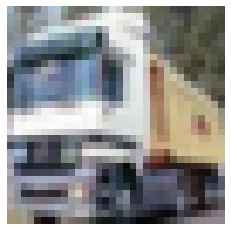

In [4]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x_train[1])
plt.axis('off')
#plt.title('first image in the training set')
plt.show()

Plot a few image to get a sense of the data

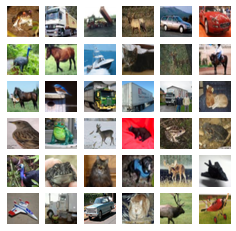

In [5]:
plt.figure(figsize=(4, 4))
for j in range(6):
    for i in range(6):
        axi = plt.subplot(6, 6, 6*j+(1+i))
        axi.imshow(x_train[6*j+i])
        axi.axis('off')
plt.show()

The `y_train` vector corresponds to one of the 10 class ids.

In [6]:
import numpy as np
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Define a list representing the image categories

In [7]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

Display the first 10 images of each class in the training set

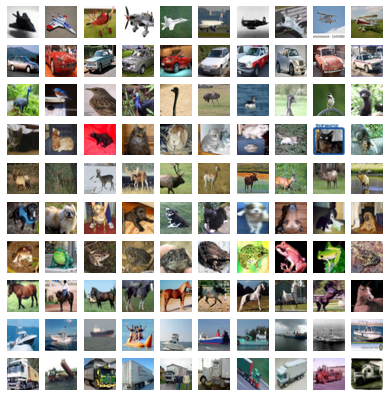

In [8]:
n = 10
plt.figure(figsize=(5.8, 5.8))  # (3.4, 3.4) for n = 6
for j in range(n):
    for i in range(n):
        axi = plt.subplot(n, n, n * j + (1 + i))
        axi.imshow(x_train[np.where(y_train == j)[0], :, :, :][i])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.savefig('cfar10_first%d.png' % (n ** 2))
plt.show()

## Model definition

k-Nearest-Neighbors (k-NN): the simplest machine learning algorithm (does not actually learn anything): classifies unknown data points by finding the  most common class among the $k$ closest examples.

The distance between data points need to be defined. Classical examples:

 - Manhattan distance $\sum_{i=1}^d|A_i - B_i|$
 - Euclidean distance $\sqrt{\sum_{i=1}^d(A_i - B_i)^2}$


Compute Euclidean and Manhattan distances between the first two images

In [9]:
A = x_train[1]
B = x_train[0]
print('Manhattan distance: {}'.format(np.sum(abs(A - B))))
print('Euclidean distance: {}'.format(np.sqrt(np.sum((A - B)^2))))

Manhattan distance: 374733
Euclidean distance: 612.2001306762356


Now prepare for training the NN-model.

First we reshape the data into large column vectors X and Y

In [10]:
# X vectors must be signed integers to avoid problems with uint8 when computing L1 distance
X_train = x_train.reshape((x_train.shape[0], -1)).astype(np.int16)
X_test = x_test.reshape((x_test.shape[0], -1)).astype(np.int16)
print('shape of train data is {}, type is {}'.format(X_train.shape, X_train.dtype))
print('shape of test data is {}, type is {}'.format(X_test.shape, X_test.dtype))

shape of train data is (50000, 3072), type is int16
shape of test data is (10000, 3072), type is int16


Use L1 (Manhattan) distance to compare images and perform nearest neighbor prediction. Note that in the case of k-NN we can touch the test set since the model is not actually learning any parameters.

In [84]:
# try the L1 distance of a random image with the first 10 images of the training set
index = np.random.randint(X_test.shape[0])
image = X_test[index]
print('using image {}'.format(index))
np.sum(np.abs(image - X_train[:10, :]), axis=1)

using image 2661


array([246841, 245800, 270164, 292366, 292614, 280838, 239048, 224645,
       268934, 349601])

Here we pick a category $k=5$ (dog), pick the first dog image in the test set and compute all $d_1$ distances. The make a prediction for this image.

index of dog image being tested: 39
[5]
993
[  993  2567 16512 16462 18016 33187  1314 26351 41521 48533]
[115500 115544 116846 117086 119584 120058 120512 120964 121026 122226]
predicted class is 5
actual class is 5


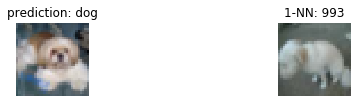

In [91]:
k = 5
# pick the first test image with category k
index_for_k = np.where(y_test == k)[0][5]
print('index of %s image being tested: %d' % (labels[k], index_for_k))
print(y_test[index_for_k])
image = x_test[index_for_k].astype(np.int16)

# compute all d1 distances
all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
min_index = np.argmin(all_d1)
print(min_index)
sorted_indices = np.argsort(all_d1)[:10]
print(sorted_indices)
print(all_d1[sorted_indices])
category = np.squeeze(y_train[min_index])

print('predicted class is %d' % category)
print('actual class is %d' % k)

ax = plt.subplot(1, 4, 1)
plt.imshow(image)
plt.axis('off')
plt.title('prediction: %s' % labels[category])
# now display the first NN
ax = plt.subplot(1, 4, 2 + i)
plt.imshow(x_train[min_index])
plt.axis('off')
plt.title('1-NN: %s' % min_index)
plt.show()

Create a vertical representation of the 10 image classes using the first one in the test set

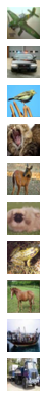

In [143]:
n = 10
plt.figure(figsize=(1, 5.8))  # (3.4, 3.4) for n = 6
for k in range(n):
    index_for_k = np.where(y_test == k)[0][3]
    axi = plt.subplot(n, 1, k + 1)
    axi.imshow(x_test[index_for_k])
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.savefig('cfar10_first_%d_test_images.png' % n)
plt.show()

Display the first 10 nearest neighbors of each test image

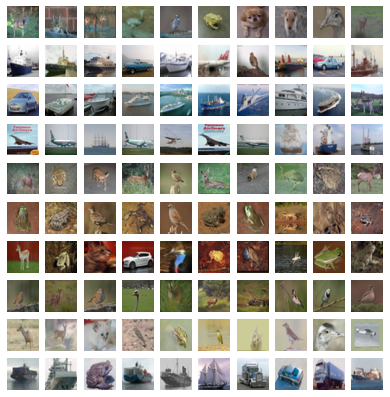

In [145]:
n = 10
plt.figure(figsize=(5.8, 5.8))  # (3.4, 3.4) for n = 6
for k in range(n):
    #index_for_k = np.where(y_test == k)[0][3]
    index_for_k = k
    image = x_test[index_for_k].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:10]
    for i in range(n):
        axi = plt.subplot(n, n, n * k + (1 + i))
        axi.imshow(x_train[sorted_indices[i]])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
#plt.savefig('cfar10_first_%d_NN.png' % n)
plt.show()

Create a visual representation of the pattern by averaging the first 10 NN

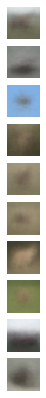

In [147]:
n = 10
plt.figure(figsize=(1, 5.8))  # (3.4, 3.4) for n = 6
for k in range(n):
    index_for_k = np.where(y_test == k)[0][3]
    image = x_test[index_for_k].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:100]
    # average the NN
    pattern = np.mean(x_train[sorted_indices], axis=0).astype(np.uint8)
    axi = plt.subplot(n, 1, k + 1)
    axi.imshow(pattern)
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.savefig('cfar10_patterns.png')
plt.show()

### Also use sklearn to perform 1-NN classification

In [12]:
print('data size in memory: {:.1f} Mb'.format(X_train.nbytes / (1024 **2 )))

data size in memory: 293.0 Mb


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [14]:
model = KNeighborsClassifier(n_neighbors=1, p=1, algorithm='brute')

In [98]:
model.fit(X_train, np.squeeze(y_train))

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')

In [99]:
model.predict(X_test[39].reshape((1, 3072)))[0]

5

In [106]:
distances_sklearn, indices_sklearn = model.kneighbors(X_test[39].reshape((1, 3072)), 3)
print(distances_sklearn)
print(indices_sklearn)

[[115500. 115544. 116846.]]
[[  993  2567 16512]]


### Comparison of our 1-NN with results from sklearn model

[  993  2567 16512]
[115500 115544 116846]


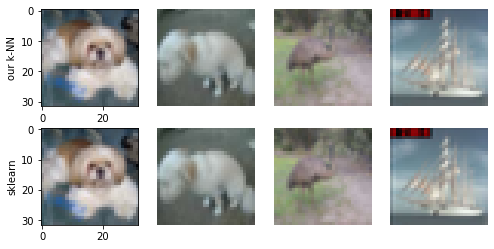

In [95]:
index = 39
image = x_test[index].astype(np.int16)
all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
sorted_indices = np.argsort(all_d1)[:3]

print(sorted_indices)
print(all_d1[sorted_indices])

plt.figure(figsize=(8, 4)) 
ax = plt.subplot(2, 4, 1)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('our k-NN')
ax = plt.subplot(2, 4, 5)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('sklearn')
for i in range(3):
    axi = plt.subplot(2, 4, (2 + i))
    axi.imshow(x_train[sorted_indices][i])
    axi.axis('off')
# compare with sklearn
indices_sklearn = [993, 2567, 16512]
distances_sklearn = [115500., 115544., 116846.]
for i in range(3):
    axi = plt.subplot(2, 4, 4 + (2 + i))
    axi.imshow(x_train[indices_sklearn][i])
    axi.axis('off')
plt.show()

### Try to change the hyper-parameters

The $k$ value and and distance metric are 2 important hyper-parameters that we can change to improve our model.

In [15]:
model_kNN = KNeighborsClassifier(n_neighbors=3, p=2)
model_kNN.fit(X_train, np.squeeze(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

[0]


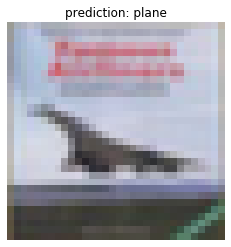

In [16]:
# test the model on a few images
k = 0
# pick the first test image with category k
index_for_k = np.where(y_test == k)[0][0]
print(y_test[index_for_k])
image = x_test[index_for_k]
category = model_kNN.predict(image.ravel().reshape((1, 3072)))[0]

plt.imshow(image)
plt.axis('off')
plt.title('prediction: %s' % labels[category])
plt.show()

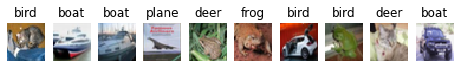

In [121]:
n = 10
predictions = model_kNN.predict(X_test[:n].reshape((n, 3072)))
plt.figure(figsize=(8, 1.5)) 
for i in range(n):
    axi = plt.subplot(1, n, (1 + i))
    axi.imshow(x_test[i])
    axi.axis('off')
    plt.title(labels[predictions[i]])
plt.show()

In [ ]:
print(classification_report(y_test, model_kNN.predict(X_test), target_names=labels))

Finally create an visual representation with 10 rows corresponding to 10 test images. Each row display the test image on the left and its the 10-NN images in the train set as computed by the model.

[49261 38299 46587 43166  1596 11769  2124 40163 33862 40468]
[[77077. 78755. 82088. 82371. 83072. 84060. 84092. 84467. 84892. 85011.]]
[ 5742 44160 28664 12556 40156 42014  7877  5180 26778 25398]
[[75961. 79544. 80237. 81386. 81607. 82794. 83478. 84883. 85039. 85644.]]
[41364 30735 46450 14276 23549 35620 46973 36788 43479 26195]
[[72373. 76144. 76641. 76938. 76951. 77391. 77758. 78031. 78600. 79391.]]
[36832  7858  1176 42034 23842 33747  6577 30162 45222 45230]
[[109072. 130502. 133319. 133896. 134801. 134895. 137666. 138268. 139276.
  140015.]]
[45382 48962 36661 34019 16779  8998 39041 10369 12277 44968]
[[100536. 103772. 104006. 104555. 105378. 105618. 108292. 108468. 108957.
  109261.]]
[ 4565 30202 12250  3649 45778 12117 21566 10105 42780 12986]
[[124835. 126457. 126632. 127179. 127766. 129004. 130776. 130803. 131943.
  132048.]]
[14226 47826 23611 32583 12619 43323 30905  8763 41249 34808]
[[77672. 78329. 78557. 80142. 80347. 80954. 83364. 83736. 84724. 85196.]]
[18444 31981

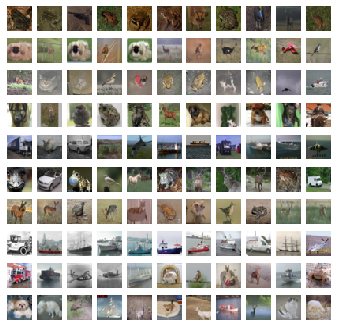

In [82]:
m = 10
offset = 30
plt.figure(figsize=(5.8, 5.8)) 
for k in range(n):
    # show the test image in the first column
    ax = plt.subplot(n, 1 + m, (m + 1) * k + 1)
    ax.imshow(x_test[offset + k])
    ax.axis('off')
    distances, indices = model_kNN.kneighbors(X_test[offset + k:offset + k + 1], m)
    for i in range(m):
        axi = plt.subplot(n, 1 + m, (m + 1) * k + (2 + i))
        axi.imshow(x_train[indices[0][i]])
        axi.axis('off')
plt.show()

One can observe the visual proximity of the image in each row. However the images are not from the same class. We can perhaps improve the predictions by increasing $k$ but the model is simply not well adapted to so different images.